In [69]:
import data, importlib
# importlib.reload(data)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cp

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import EfficientFrontier, objective_functions, base_optimizer

In [70]:
tickers = ["BTCUSDT", "DOGEUSDT", "ETHUSDT", "SOLUSDT", "XRPUSDT"]
sampling = "1d"

start_date = pd.Timestamp('2022-01-01')
start_test_date = pd.Timestamp('2023-06-01')
end_date = pd.Timestamp('2024-01-01')

windows = [7, 30, 80, 240, 720]
filters = ['linear', 'gaussian']
constraints = [1, 0.1]

portfolio_k0nfig = {
    **{
        f'LIN{window}': {
            'window': window,
            'filter': 'linear',
            'constraint': 1
        } for window in windows
    },
    **{
        f'GAU{window}': {
            'window': window,
            'filter': 'gaussian',
            'constraint': 1
        } for window in windows
    },
    **{
        f'CON{window}': {
            'window': window,
            'filter': 'linear',
            'constraint': 0.05
        } for window in windows
    }
}

Rf = 0.0001
meta_MCD_constraint = 0.01
portfolio_capital = 1000 # USDT
portfolio_BNB_not_USDT = True

In [71]:
all_crypto = { ticker: data.index_days(data.load_asset(ticker, sampling))["Open"]  for ticker in (tickers + ["BNBUSDT"]) }
def get_prices(date):
    return {
        ticker: series[date]
        for ticker, series in all_crypto.items()
    }


def calculate_fees(weight_old, weight_new, capital=portfolio_capital, BNB_not_USDT=portfolio_BNB_not_USDT, date=None):
    """
    Simulate Binance transaction fees for portfolio rebalancing using current fee rules.
    
    Parameters:
        weight_old (dict): Current portfolio weights (sum to 1).
        weight_new (dict): Desired portfolio weights (sum to 1).
        capital (float): Total portfolio capital in USDT or BNB.
        BNB_not_USDT (bool): Whether portfolio is denominated in BNB.
        date (datetime): Passed to `get_prices` to get historical pricing.
        get_prices (callable): Function that returns dict of asset prices in USDT.
    
    Returns:
        total_fee_usdt (float): Estimated transaction fee in USDT-equivalent.
        trades (dict): Dictionary of trade volumes and fees per asset.
    """
    prices_usdt = get_prices(date)
    
    # Convert BNB capital to USDT if needed
    if BNB_not_USDT:
        assert "BNBUSDT" in prices_usdt, "BNB price required for capital conversion."
        capital_usdt = capital * prices_usdt["BNBUSDT"]
    else:
        capital_usdt = capital

    assets = set(weight_old.keys()) | set(weight_new.keys())
    trades = {}
    total_fee_usdt = 0.0

    # Binance discount if paying with BNB
    fee_rate = 0.00075 if BNB_not_USDT else 0.0010

    for asset in assets:
        old_w = weight_old.get(asset, 0)
        new_w = weight_new.get(asset, 0)
        delta_weight = new_w - old_w
        asset_price = prices_usdt.get(asset)

        if delta_weight == 0 or asset_price is None:
            continue

        trade_value = abs(delta_weight) * capital_usdt  # USDT value of trade
        fee = fee_rate * trade_value
        total_fee_usdt += fee

        trades[asset] = {
            "trade_direction": "buy" if delta_weight > 0 else "sell",
            "trade_value_usdt": trade_value,
            "fee_usdt": fee,
            "units_traded": trade_value / asset_price,
        }

    return total_fee_usdt, trades


In [72]:
# load the returns for each trading period day

assets = [ data.load_asset(ticker, sampling) for ticker in tickers]
assets = [ data.index_days(df) for df in assets ]
asset_returns = { ticker: data.add_returns(df)["Return"] for (ticker, df) in zip(tickers, assets) }


# === UTILS ===
def gaussian_weights(n):
    half = norm.pdf(np.linspace(-2, 0, n))
    return half / half.sum()

# === RETURNS, WEIGHTS, DIFFS ===
def get_rets_weights_diffs(k0nfig):
    window = k0nfig["window"]
    filt = k0nfig["filter"]
    constraint = k0nfig["constraint"]

    returns = []
    weights = []
    diffs = []
    index = []

    prev_weights = None
    dates = asset_returns[tickers[0]].loc[start_test_date:end_date].index

    for date in dates:
        hist_returns_df = pd.DataFrame({t: asset_returns[t].loc[:date].iloc[-window:] for t in tickers})
        if len(hist_returns_df) < window:
            continue

        if filt == "gaussian":
            weights_ = gaussian_weights(len(hist_returns_df))
            hist_returns_df = hist_returns_df.multiply(weights_, axis=0)

        mu = hist_returns_df.mean()
        S = hist_returns_df.cov()

        ef = EfficientFrontier(mu, S)
        try:
            raw_weights = ef.max_sharpe(risk_free_rate=Rf)
            cleaned_weights = ef.clean_weights()
        except:
            cleaned_weights = weights[-1] if len(weights) > 0 else { key: 1 / len(tickers) for key in tickers} # use previous days weights

        if prev_weights is not None and constraint < 1:
            constrained_weights = {}
            for asset in tickers:
                delta = cleaned_weights.get(asset, 0) - prev_weights.get(asset, 0)
                delta = np.clip(delta, -constraint, constraint)
                constrained_weights[asset] = prev_weights.get(asset, 0) + delta
            total = sum(constrained_weights.values())
            cleaned_weights = {k: v / total for k, v in constrained_weights.items()}

        rets = sum(cleaned_weights[a] * asset_returns[a].loc[date] for a in tickers)

        weights.append(cleaned_weights)
        diffs.append({a: cleaned_weights.get(a, 0) - prev_weights.get(a, 0) if prev_weights else cleaned_weights.get(a, 0) for a in tickers})
        returns.append(rets)
        index.append(date)
        prev_weights = cleaned_weights

    return pd.Series(returns, index=index), weights, diffs

# === RUN SIMULATION ===
portfolios = {}
for key, k0nfig in portfolio_k0nfig.items():
    portfolios[key] = {}
    portfolios[key]['returns'], portfolios[key]['weights'], portfolios[key]['diffs'] = get_rets_weights_diffs(k0nfig)

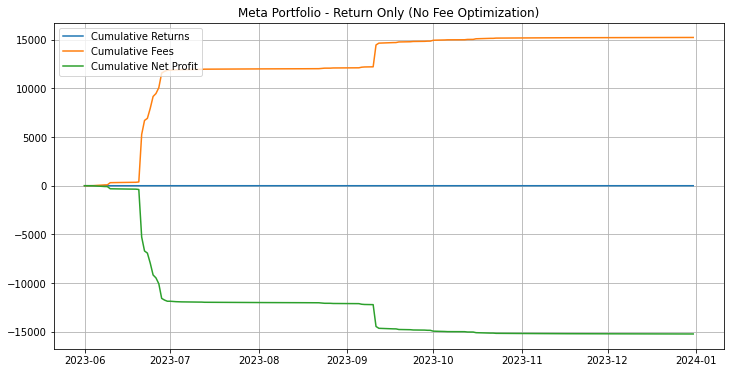

Meta Portfolio - Return Only (No Fee Optimization) Sharpe Ratio (net of fees): -3.3407


In [73]:

# === META-RNF ===
def run_meta_RNF():
    meta_RNF_returns = []
    meta_RNF_fees = [0]
    meta_RNF_weights = []

    prev_weights = {key: 1 / len(portfolios) for key in portfolios}

    for i, date in enumerate(portfolios[list(portfolios.keys())[0]]['returns'].index):
        past = {key: portfolios[key]['returns'].iloc[:i] for key in portfolios}
        mu = {k: v.mean() for k, v in past.items() if len(v) > 0}
        if not mu:
            continue

        mu_series = pd.Series(mu)
        mu_series = mu_series / mu_series.sum()
        curr_weights = mu_series.to_dict()
        meta_RNF_weights.append(curr_weights)

        daily_return = sum(
            curr_weights[k] * portfolios[k]['returns'].iloc[i] for k in curr_weights
        )
        meta_RNF_returns.append(daily_return)

        if len(meta_RNF_weights) > 1:
            old_weights = meta_RNF_weights[-2]
            delta = {
                key: curr_weights.get(key, 0) - old_weights.get(key, 0)
                for key in set(curr_weights) | set(old_weights)
            }

            asset_delta = {a: 0 for a in tickers}
            for k, w_change in delta.items():
                for a, d in portfolios[k]['diffs'][i].items():
                    asset_delta[a] += w_change * d

            fee_usdt, _ = calculate_fees({a: 0 for a in tickers}, asset_delta, date=date)
        else:
            fee_usdt = 0

        meta_RNF_fees.append(fee_usdt)

    return pd.Series(meta_RNF_returns, index=portfolios[list(portfolios.keys())[0]]['returns'].index[:len(meta_RNF_returns)]), \
           pd.Series(meta_RNF_fees[1:], index=portfolios[list(portfolios.keys())[0]]['returns'].index[:len(meta_RNF_returns)])

# === PLOTTING ===
def plot_results(returns, fees, title):
    cum_rets = (1 + returns).cumprod()
    cum_fees = fees.cumsum()
    cum_net = cum_rets - cum_fees

    plt.figure(figsize=(12, 6))
    plt.plot(cum_rets, label="Cumulative Returns")
    plt.plot(cum_fees, label="Cumulative Fees")
    plt.plot(cum_net, label="Cumulative Net Profit")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    net_returns = returns - fees
    sharpe = (net_returns.mean() / net_returns.std()) * np.sqrt(365)
    print(f"{title} Sharpe Ratio (net of fees): {sharpe:.4f}")

meta_rnf_returns, meta_rnf_fees = run_meta_RNF()
plot_results(meta_rnf_returns, meta_rnf_fees, "Meta Portfolio - Return Only (No Fee Optimization)")


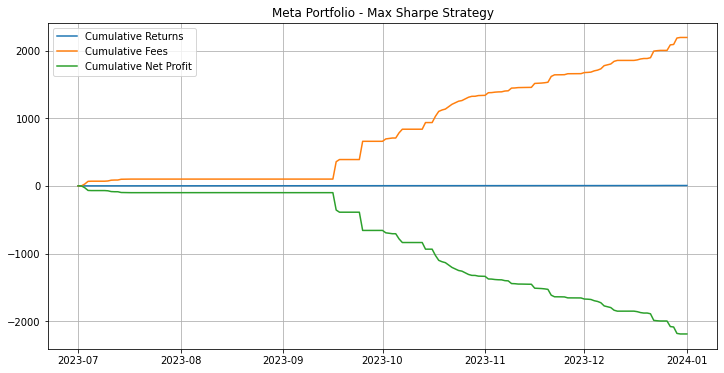

Meta Portfolio - Max Sharpe Strategy Sharpe Ratio (net of fees): -6.8350


In [74]:
def run_meta_max_sharpe(window=30, risk_free_rate=0.0):
    meta_returns = []
    meta_fees = []
    meta_weights = []

    prev_weights = {key: 1 / len(portfolios) for key in portfolios}  # start with uniform weights
    portfolio_keys = list(portfolios.keys())
    dates = portfolios[portfolio_keys[0]]['returns'].index

    for i, date in enumerate(dates):
        if i < window:
            continue  # not enough data for optimization window

        # Get historical returns of each sub-portfolio over the window
        hist_returns = {
            key: portfolios[key]['returns'].iloc[i - window:i]
            for key in portfolio_keys
        }
        df_returns = pd.DataFrame(hist_returns)

        mu = df_returns.mean()
        S = df_returns.cov()

        try:
            ef = EfficientFrontier(mu, S)
            weights_opt = ef.max_sharpe(risk_free_rate=risk_free_rate)
            weights_clean = ef.clean_weights()
        except:
            weights_clean = prev_weights.copy()  # fallback to previous weights on failure

        meta_weights.append(weights_clean)

        # Compute daily return from meta portfolio
        daily_return = sum(
            weights_clean[k] * portfolios[k]['returns'].iloc[i] for k in weights_clean
        )
        meta_returns.append(daily_return)

        # Compute transaction cost
        if len(meta_weights) > 1:
            old_weights = meta_weights[-2]
            delta = {
                key: weights_clean.get(key, 0) - old_weights.get(key, 0)
                for key in set(weights_clean) | set(old_weights)
            }

            asset_delta = {a: 0 for a in tickers}
            for k, w_change in delta.items():
                for a, d in portfolios[k]['diffs'][i].items():
                    asset_delta[a] += w_change * d

            fee_usdt, _ = calculate_fees({a: 0 for a in tickers}, asset_delta, date=date)
        else:
            fee_usdt = 0

        meta_fees.append(fee_usdt)
        prev_weights = weights_clean

    result_index = dates[window:window + len(meta_returns)]
    return pd.Series(meta_returns, index=result_index), pd.Series(meta_fees, index=result_index)

meta_sharpe_returns, meta_sharpe_fees = run_meta_max_sharpe(window=30, risk_free_rate=Rf)
plot_results(meta_sharpe_returns, meta_sharpe_fees, "Meta Portfolio - Max Sharpe Strategy")

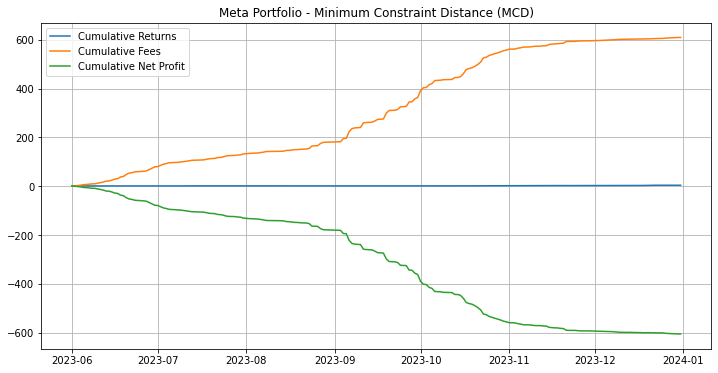

Meta Portfolio - Minimum Constraint Distance (MCD) Sharpe Ratio (net of fees): -11.9339


In [75]:
# === META-MCD ===
def run_meta_MCD(constraint=0.02):
    meta_MCD_returns = []
    meta_MCD_fees = []
    meta_MCD_weights = []

    prev_weights = {key: 1 / len(portfolios) for key in portfolios}  # Equal weights to start

    for i, date in enumerate(portfolios[list(portfolios.keys())[0]]['returns'].index):
        # Compute RNF target weights (past mean returns)
        past = {key: portfolios[key]['returns'].iloc[:i] for key in portfolios}
        mu = {k: v.mean() for k, v in past.items() if len(v) > 0}
        if not mu:
            continue

        target_weights = pd.Series(mu)
        target_weights = target_weights / target_weights.sum()
        target_weights = target_weights.to_dict()

        # Constrain movement from previous weights
        constrained_weights = {}
        for asset in portfolios:
            delta = target_weights.get(asset, 0) - prev_weights.get(asset, 0)
            delta = np.clip(delta, -constraint, constraint)
            constrained_weights[asset] = prev_weights.get(asset, 0) + delta

        # Normalize to sum to 1
        total = sum(constrained_weights.values())
        constrained_weights = {k: v / total for k, v in constrained_weights.items()}
        meta_MCD_weights.append(constrained_weights)

        # Compute daily return
        daily_return = sum(
            constrained_weights[k] * portfolios[k]['returns'].iloc[i] for k in constrained_weights
        )
        meta_MCD_returns.append(daily_return)

        # Compute fee
        if len(meta_MCD_weights) > 1:
            delta_weights = {
                key: constrained_weights.get(key, 0) - meta_MCD_weights[-2].get(key, 0)
                for key in set(constrained_weights) | set(meta_MCD_weights[-2])
            }

            asset_delta = {a: 0 for a in tickers}
            for k, w_change in delta_weights.items():
                for a, d in portfolios[k]['diffs'][i].items():
                    asset_delta[a] += w_change * d

            fee_usdt, _ = calculate_fees({a: 0 for a in tickers}, asset_delta, date=date)
        else:
            fee_usdt = 0

        meta_MCD_fees.append(fee_usdt)
        prev_weights = constrained_weights

    aligned_index = portfolios[list(portfolios.keys())[0]]['returns'].index[:len(meta_MCD_returns)]
    return pd.Series(meta_MCD_returns, index=aligned_index), pd.Series(meta_MCD_fees, index=aligned_index)

meta_mcd_returns, meta_mcd_fees = run_meta_MCD(constraint=meta_MCD_constraint)
plot_results(meta_mcd_returns, meta_mcd_fees, "Meta Portfolio - Minimum Constraint Distance (MCD)")

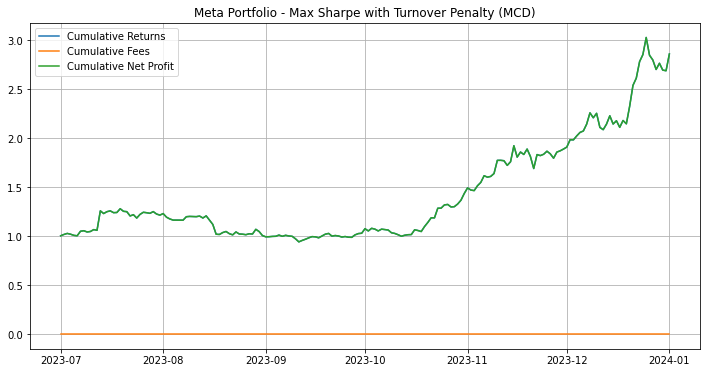

Meta Portfolio - Max Sharpe with Turnover Penalty (MCD) Sharpe Ratio (net of fees): 3.7151


In [76]:
debug = {}

def run_meta_MCD_max_sharpe(window=30, risk_free_rate=0.0, lambda_penalty=1.0):
    meta_returns = []
    meta_fees = []
    meta_weights = []

    debug["diffs"] = []

    prev_weights = {key: 1 / len(portfolios) for key in portfolios}
    portfolio_keys = list(portfolios.keys())
    dates = portfolios[portfolio_keys[0]]['returns'].index

    for i, date in enumerate(dates):
        if i < window:
            continue  # not enough data

        # Historical returns of each portfolio
        hist_returns = {
            key: portfolios[key]['returns'].iloc[i - window:i]
            for key in portfolio_keys
        }
        df_returns = pd.DataFrame(hist_returns)

        mu = df_returns.mean()
        S = df_returns.cov()

        try:
            ef = EfficientFrontier(mu, S)

            # Add L2 regularization around previous weights to penalize turnover
            prev_w = np.array([prev_weights.get(k, 0) for k in portfolio_keys])
            ef.add_objective(objective_functions.L2_reg, gamma=lambda_penalty, weights=prev_w)
            print("try block execution never gets here")


            weights_opt = ef.max_sharpe(risk_free_rate=risk_free_rate)
            weights_clean = ef.clean_weights()
        except:
            weights_clean = prev_weights.copy()

        meta_weights.append(weights_clean)

        # Compute daily return
        daily_return = sum(
            weights_clean[k] * portfolios[k]['returns'].iloc[i] for k in weights_clean
        )
        meta_returns.append(daily_return)

        # Compute turnover costs
        if len(meta_weights) > 1:
            old_weights = meta_weights[-2]
            delta = {
                key: weights_clean.get(key, 0) - old_weights.get(key, 0)
                for key in set(weights_clean) | set(old_weights)
            }

            asset_delta = {a: 0 for a in tickers}
            for k, w_change in delta.items():
                for a, d in portfolios[k]['diffs'][i].items():
                    asset_delta[a] += w_change * d

            debug["diffs"].append(asset_delta)

            fee_usdt, _ = calculate_fees({a: 0 for a in tickers}, asset_delta, date=date)
        else:
            fee_usdt = 0

        meta_fees.append(fee_usdt)
        prev_weights = weights_clean

    result_index = dates[window:window + len(meta_returns)]
    return pd.Series(meta_returns, index=result_index), pd.Series(meta_fees, index=result_index)

meta_mcd_returns, meta_mcd_fees = run_meta_MCD_max_sharpe(window=30, risk_free_rate=Rf, lambda_penalty=3.0)
plot_results(meta_mcd_returns, meta_mcd_fees, "Meta Portfolio - Max Sharpe with Turnover Penalty (MCD)")


c:\Users\iansa\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exc

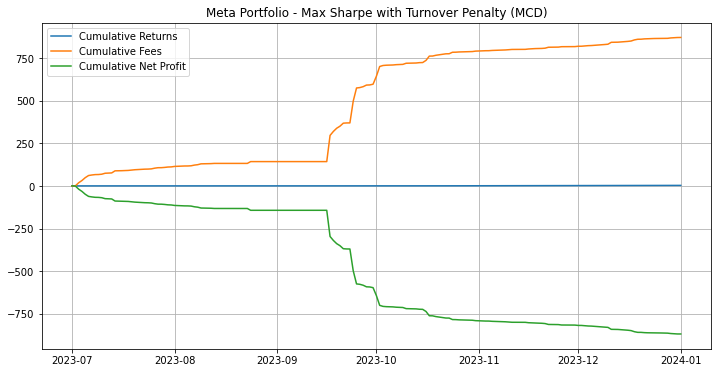

Meta Portfolio - Max Sharpe with Turnover Penalty (MCD) Sharpe Ratio (net of fees): -5.3798


In [77]:
debug = {}



def run_meta_MCD_max_sharpe(window=30, risk_free_rate=0.0, lambda_penalty=1.0):
    meta_returns = []
    meta_fees = []
    meta_weights = []

    prev_weights = {key: 1 / len(portfolios) for key in portfolios}
    portfolio_keys = list(portfolios.keys())
    dates = portfolios[portfolio_keys[0]]['returns'].index

    for i, date in enumerate(dates):
        if i < window:
            continue  # not enough data

        # Historical returns of each portfolio
        hist_returns = {
            key: portfolios[key]['returns'].iloc[i - window:i]
            for key in portfolio_keys
        }
        df_returns = pd.DataFrame(hist_returns)

        mu = df_returns.mean()
        S = df_returns.cov()

        try:
            ef = EfficientFrontier(mu, S)
            def L2_from_target(w, target_weights, gamma=1.0):
                t = np.array([target_weights.get(k, 0) for k in ef.tickers])
                return gamma * cp.sum_squares(w - t)
            
            # Add L2 regularization around previous weights to penalize turnover
            prev_w = np.array([prev_weights.get(k, 0) for k in portfolio_keys])
            ef.add_objective(L2_from_target, target_weights=prev_weights, gamma=lambda_penalty)
            weights_opt = ef.max_sharpe(risk_free_rate=risk_free_rate)
            weights_clean = ef.clean_weights()
        except Exception as e:
            print(e)
            weights_clean = prev_weights.copy()

        meta_weights.append(weights_clean)

        # Compute daily return
        daily_return = sum(
            weights_clean[k] * portfolios[k]['returns'].iloc[i] for k in weights_clean
        )
        meta_returns.append(daily_return)

        # Compute turnover costs
        if len(meta_weights) > 1:
            old_weights = meta_weights[-2]
            delta = {
                key: weights_clean.get(key, 0) - old_weights.get(key, 0)
                for key in set(weights_clean) | set(old_weights)
            }

            asset_delta = {a: 0 for a in tickers}
            for k, w_change in delta.items():
                for a, d in portfolios[k]['diffs'][i].items():
                    asset_delta[a] += w_change * d

            fee_usdt, _ = calculate_fees({a: 0 for a in tickers}, asset_delta, date=date)
        else:
            fee_usdt = 0

        meta_fees.append(fee_usdt)
        prev_weights = weights_clean

    result_index = dates[window:window + len(meta_returns)]
    
    debug["meta_weights"] = meta_weights

    return pd.Series(meta_returns, index=result_index), pd.Series(meta_fees, index=result_index)

meta_mcd_returns, meta_mcd_fees = run_meta_MCD_max_sharpe(window=30, risk_free_rate=Rf, lambda_penalty=3.0)
plot_results(meta_mcd_returns, meta_mcd_fees, "Meta Portfolio - Max Sharpe with Turnover Penalty (MCD)")


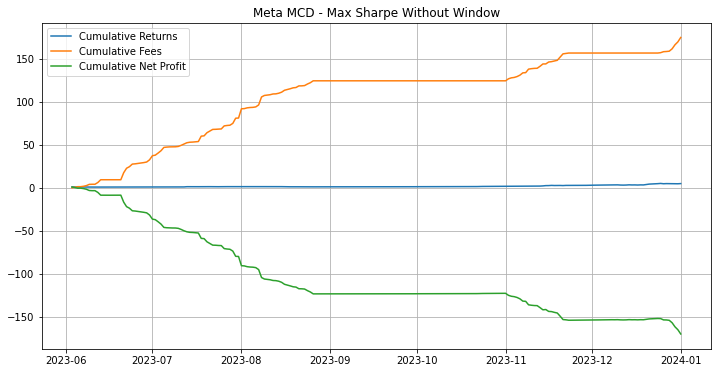

Meta MCD - Max Sharpe Without Window Sharpe Ratio (net of fees): -9.6532


In [78]:
def run_meta_MCD_max_sharpe_no_window(risk_free_rate=0.0, constraint=0.02):
    meta_MCD_returns = []
    meta_MCD_fees = []
    meta_MCD_weights = []

    portfolio_keys = list(portfolios.keys())
    dates = portfolios[portfolio_keys[0]]['returns'].index
    prev_weights = {key: 1 / len(portfolio_keys) for key in portfolio_keys}

    for i, date in enumerate(dates):
        if i < 2:
            continue  # not enough data to form historical estimate

        # Use full return history up to current time
        hist_returns = {
            key: portfolios[key]['returns'].iloc[:i]
            for key in portfolio_keys
        }
        df_returns = pd.DataFrame(hist_returns)

        mu = df_returns.mean()
        S = df_returns.cov()

        try:
            ef = EfficientFrontier(mu, S)
            opt_weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
            target_weights = ef.clean_weights()
        except:
            target_weights = prev_weights.copy()

        # Apply movement constraint
        constrained_weights = {}
        for asset in portfolio_keys:
            delta = target_weights.get(asset, 0) - prev_weights.get(asset, 0)
            delta = np.clip(delta, -constraint, constraint)
            constrained_weights[asset] = prev_weights.get(asset, 0) + delta

        # Normalize weights
        total = sum(constrained_weights.values())
        constrained_weights = {k: v / total for k, v in constrained_weights.items()}
        meta_MCD_weights.append(constrained_weights)

        # Compute meta return
        daily_return = sum(
            constrained_weights[k] * portfolios[k]['returns'].iloc[i]
            for k in constrained_weights
        )
        meta_MCD_returns.append(daily_return)

        # Compute fee
        if len(meta_MCD_weights) > 1:
            delta_weights = {
                key: constrained_weights.get(key, 0) - meta_MCD_weights[-2].get(key, 0)
                for key in set(constrained_weights) | set(meta_MCD_weights[-2])
            }

            asset_delta = {a: 0 for a in tickers}
            for k, w_change in delta_weights.items():
                for a, d in portfolios[k]['diffs'][i].items():
                    asset_delta[a] += w_change * d

            fee_usdt, _ = calculate_fees({a: 0 for a in tickers}, asset_delta, date=date)
        else:
            fee_usdt = 0

        meta_MCD_fees.append(fee_usdt)
        prev_weights = constrained_weights

    aligned_index = dates[2:2 + len(meta_MCD_returns)]
    return pd.Series(meta_MCD_returns, index=aligned_index), pd.Series(meta_MCD_fees, index=aligned_index)

meta_mcd_sharpe_returns, meta_mcd_sharpe_fees = run_meta_MCD_max_sharpe_no_window(risk_free_rate=Rf, constraint=meta_MCD_constraint)
plot_results(meta_mcd_sharpe_returns, meta_mcd_sharpe_fees, "Meta MCD - Max Sharpe Without Window")